In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes
from data_functions import make_date_to_MYR

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
%%time
p = '../tempNN/'
treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

pmpm = pd.read_pickle(p+'pmpm.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

#treated['Treatment'] = 1
#controls['Treatment'] = 0

CPU times: user 10.8 s, sys: 11.3 s, total: 22.1 s
Wall time: 22.1 s


In [4]:
def findDate(dat, dat2,  past_months):
    
    first = dat[['PERS_ID', 'MYR']].groupby('PERS_ID').apply(lambda x : x.iloc[0]).reset_index(drop = True)
    first['year'] = (first.MYR//100).astype(int)
    first['month'] = (first.MYR%100).astype(int)
    first['day'] = 1
    first['REG_DATE'] = pd.to_datetime(first[['year','month','day']])
    first['PAST_DATE'] = (first.REG_DATE - pd.DateOffset(months = past_months)).apply(make_date_to_MYR)
    first['REG_DATE'] = first['REG_DATE'].apply(make_date_to_MYR)
    first = first[['PERS_ID',  'REG_DATE', 'PAST_DATE']]
    dat2['PERS_ID'] = dat2.PERS_ID.astype(int)
    first['PERS_ID'] = first.PERS_ID.astype(int)

    dat3 =  dat2.merge(first, how = 'right', on = 'PERS_ID')
    dat3['IN_STUDY'] = 0
   # dat2['PERS_ID'] = dat2.PERS_ID.astype(int)
   # dat['PERS_ID'] = dat.PERS_ID.astype(int)

   # dat_all_months = dat2.merge(dat['PERS_ID','REG', how = 'right', on = 'PERS_ID')
    return dat3
    

In [5]:
treated2 = findDate(treated, pmpm.copy(), 6)
controls2 = findDate(controls, pmpm.copy(), 6)

In [6]:
def firstdate(group):
    date = group['PAST_DATE'].iloc[0]
    if date in group.MYR.unique():
        group = group[group.MYR >= date]
        group['IN_STUDY'] = 1
    return group

def filter_first_date(data):
    data = data.groupby('PERS_ID').apply(firstdate)
    filt = data['IN_STUDY'] == 1
    data = data[filt].reset_index(drop = True)
    return data

In [7]:
treated2 = (filter_first_date(treated2)).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls2 = (filter_first_date(controls2)).sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

controls2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
treated2['Treatment'] = 1
controls2['Treatment'] = 0


In [8]:
data = [treated2,  controls2]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [9]:
times = [0, 6, 12]
curves = []
for time in times:
    survTr = treated2.copy().groupby('PERS_ID').apply(survival_diabetes,  grace = time).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
    survCo = controls2.copy().groupby('PERS_ID').apply(survival_diabetes, grace = time).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
    curves.append((survTr, survCo))
    
    

In [10]:
filter_cols =  ['AGE_AT_MIDMONTH',  'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [11]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [12]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

In [13]:
#from lifelines import KaplanMeierFitter


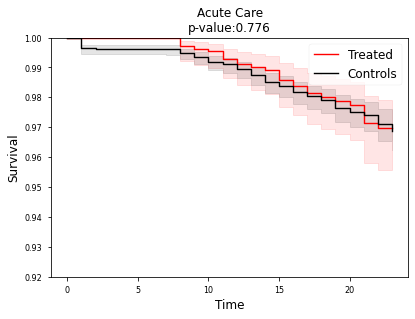

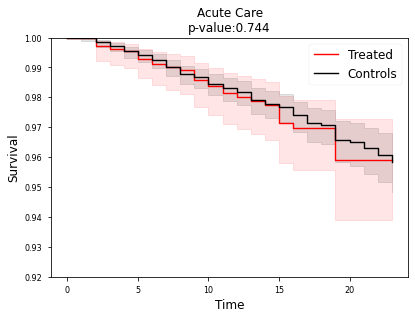

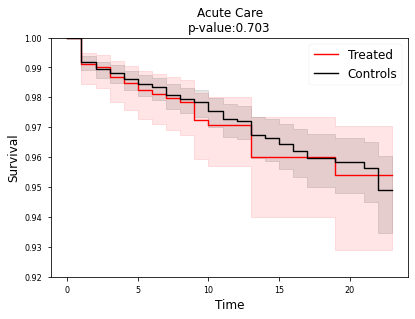

In [14]:
rmsts = []
for (tr, cr) in curves:
    fitted, rmst = survival_fit_res( ['Treated', 'Controls'],  tr, cr,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)
    
    rmsts.append(rmst)
    outcome = 'Acute Care'
    logrank_summ = logrank_test(tr['T'], cr['T'], event_observed_A=tr['E'], event_observed_B=cr['E'] ).summary
    fig, ax = plt.subplots()
    for name, mod in fitted.items():
        
        #plot data on the axes
        ax = mod.plot(**kaplan_plot_params, ax = ax)
        
    
    #customize plots
    ax.collections[0].set_color('r')
    ax.collections[1].set_color('k')
    ax.set_xlabel('Time', fontsize =12)
    ax.set_ylabel('Survival', fontsize = 12)
    ax.lines[0].set_color('r')
    ax.lines[1].set_color('k')
    ax.legend(list(fitted.keys()), fontsize = 12)
    ax.set_ylim([0.92,1])
    if outcome_title:
        ax.set_title(outcome+'\np-value:'+'{:.3f}'.format(logrank_summ['p'].iloc[0]), fontsize = 12)


    

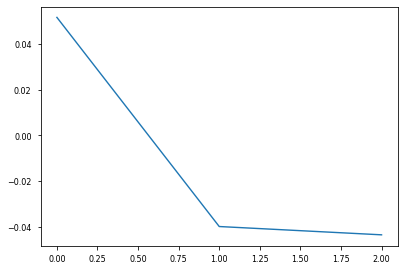

In [15]:
fig, ax = plt.subplots()
ax.plot(rmsts)
plt.show()